In [5]:
#Imported Libraries
import numpy as np
import pmdarima as ar
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import csv
import math

          date  sales
0   2018-01-01  23923
1   2018-02-01  12531
2   2018-03-01  28479
3   2018-04-01  31897
4   2018-05-01  17087
..         ...    ...
151 2030-08-01      0
152 2030-09-01      0
153 2030-10-01      0
154 2030-11-01      0
155 2030-12-01      0

[156 rows x 2 columns]


<AxesSubplot:xlabel='date'>

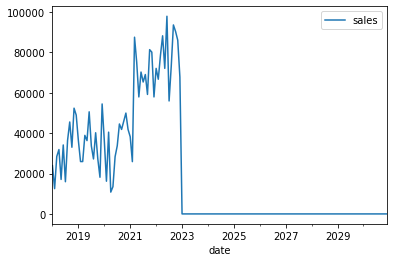

In [48]:
# Cleaning + Prelim Graph
sales = pd.read_csv('plugin_monthly_sales.csv')
sales = sales.drop("sales_before",axis=1)
sales = sales.drop("sales_next",axis=1)
yearly_multipliers = [1.139198301,1.297546012,1.350649351,1.233552632,1.076566125]

counter = 0
for i in yearly_multipliers:
    for j in range(12):
        sales["sales"][counter] *= i
        counter+=1

for i in range(96):
    sales = sales.append({"year":2023+(i//12), "month": i%12 + 1,'sales':0},ignore_index=True)

sales['date'] = pd.to_datetime(dict(year=sales.year, month=sales.month,day=1))
sales = sales.drop("year",axis=1)
sales = sales.drop("month",axis=1)
sales = sales[["date",'sales']]
print(sales)

sales.set_index("date",inplace=True)
sales.plot()



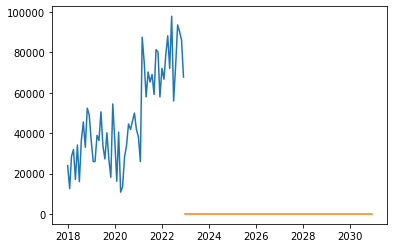

In [49]:
# Train and Test Value
train = sales[:60]
test = sales[-96:]
plt.plot(train)
plt.plot(test)

In [50]:
# Arima Model Analysis
arima_model = ar.auto_arima(train,start_p=0,d=1,start_q=0,max_p=5,max_d=5,max_q=5,start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=12,
seasonal=True,error_action='warn',trace=True,suppress_warnings=True,stepwise=True,random_state=20,n_fits=50)

arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1069.072, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1060.628, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1050.253, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1061.569, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1052.157, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1052.099, Time=0.58 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1055.353, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1054.187, Time=0.73 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1059.231, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1051.602, Time=0.14 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1050.649, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1054.608, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1049.735, Time=0.31 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(1,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -519.868
Date:                              Sun, 05 Mar 2023   AIC                           1049.735
Time:                                      10:58:37   BIC                           1058.986
Sample:                                  01-01-2018   HQIC                          1053.216
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7459      0.332     -2.247      0.025      -1.396      -0.095
ma.L1          0.2639      0.398      0.664      0.507      -0.515       1.043
ma.L2         -0.6474      0.285     -2.268      0.023      -1.207      -0.088
ma.S.L12      -0.6855      0.405     -1.691      0.091      -1.480       0.109
sigma2      3.247e+08   9.16e-10   3.55e+17      0.000    3.25e+08    3.25e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.75
Prob(Q):                              0.88   Prob(JB):                         0.03
Heteroskedasticity (H):               0.85   Skew:                             0.50
Prob(H) (two-sided):                  0.75   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+33. Standard errors may be unstable.
"""

In [52]:
# Prediction Table
prediction = pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns = ['predicted_sales']
print(prediction)

            predicted_sales
date                       
2023-01-01     82374.740980
2023-02-01     70797.029660
2023-03-01     95037.055892
2023-04-01     91618.363362
2023-05-01     81917.501490
...                     ...
2030-08-01    187849.674548
2030-09-01    194288.612797
2030-10-01    196089.144073
2030-11-01    195914.468503
2030-12-01    187725.832689

[96 rows x 1 columns]


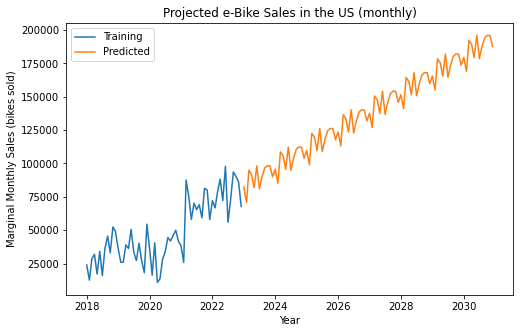

In [66]:
# Graph of final values
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(prediction,label="Predicted")
plt.legend(loc = "upper left")
plt.title("Projected e-Bike Sales in the US (monthly)")
plt.xlabel("Year")
plt.ylabel("Marginal Monthly Sales (bikes sold)")
plt.show()

In [65]:
# Values for Year
print(prediction.iloc[[24]])
print(prediction.iloc[[27]])
print(prediction.iloc[[30]])
print(prediction.iloc[[33]])
count_2025 = 0
for i in range(24,36):
    count_2025 += prediction.iloc[i]['predicted_sales']
print(count_2025)
print()
print(prediction.iloc[[60]])
print(prediction.iloc[[63]])
print(prediction.iloc[[66]])
print(prediction.iloc[[69]])
count_2028 = 0
for i in range(60,72):
    count_2028 += prediction.iloc[i]['predicted_sales']
print(count_2028)

            predicted_sales
date                       
2025-01-01     109704.90081
            predicted_sales
date                       
2025-04-01    119782.264858
            predicted_sales
date                       
2025-07-01     108908.19192
            predicted_sales
date                       
2025-10-01    126290.693041
1408959.7626945123

            predicted_sales
date                       
2028-01-01    151583.430072
            predicted_sales
date                       
2028-04-01    161661.528648
            predicted_sales
date                       
2028-07-01    150787.150862
            predicted_sales
date                       
2028-10-01    168169.778502
1911508.0544426811


In [68]:
# Sensitivity
actualJan2023 = 86000
predictedJan2023 = 82374.740980

percentError = (predictedJan2023-actualJan2023)/actualJan2023 * 100
print(percentError)

-4.215417465116277
